In [1]:
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.optimizers import RMSprop, Adam, SGD
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping
from keras.layers import Flatten, Reshape, BatchNormalization, Activation, LeakyReLU, Input, GaussianNoise
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import UpSampling2D
from keras import backend as K
K.set_image_dim_ordering('tf')
import matplotlib.pyplot as plt

C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# For reproducibility
np.random.seed(42)

In [3]:
# Load the dataset
(X_train_init, Y_train_init), (X_test_init, Y_test_init) = cifar10.load_data()

In [4]:
X_train_init = (X_train_init.astype(np.float32) - 127.5)/127.5
X_test_init = (X_test_init.astype(np.float32) - 127.5)/127.5

In [15]:
def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2
    cropped_img = np.copy(img[starty:starty+cropy, startx:startx+cropx, :])
    masked_img = img.copy()
    masked_img[starty:starty+cropy, startx:startx+cropx, :] = 0
    return (masked_img, cropped_img)

In [6]:
X_train = []
Y_train = []
for i in X_train_init:
    img = crop_center(i, 16, 16)
    X_train.append(img[0])
    Y_train.append(img[1])

In [7]:
X_test = []
Y_test = []
for i in X_test_init:
    img = crop_center(i, 16, 16)
    X_test.append(img[0])
    Y_test.append(img[1])

In [8]:
X_train_array = np.array(X_train)
Y_train_array = np.array(Y_train)
X_test_array = np.array(X_test)
Y_test_array = np.array(Y_test)

In [11]:
def build_generator():

    model = Sequential()

    # Encoder
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(32,32,3), padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    # Fully Connected
    model.add(Flatten())
    model.add(Dense(2048))
    model.add(Reshape((2,2,512)))
    
    # Decoder
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))
    model.add(Conv2D(3, kernel_size=3, padding="same"))
    model.add(Activation('tanh'))


    masked_img = Input(shape=(32,32,3))
    gen_missing = model(masked_img)

    return Model(masked_img, gen_missing)

def build_discriminator():

    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(16,16,3), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=(16,16,3))
    validity = model(img)

    return Model(img, validity)

In [12]:
d_optim = Adam(lr=0.00002, beta_1=0.5, beta_2=0.999)
g_optim = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999)

model_discriminator = build_discriminator()
model_discriminator.compile(loss='binary_crossentropy',
            optimizer=d_optim,
            metrics=['accuracy'])

model_generator = build_generator()

masked_img = Input(shape=(32,32,3))
gen_missing = model_generator(masked_img)
model_discriminator.trainable = False

valid = model_discriminator(gen_missing)

model_gan = Model(masked_img , [gen_missing, valid])
model_gan.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=g_optim)

In [13]:
def train(train_steps=1000000, batch_size=64):
    for i in range(train_steps):
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        # Random input
        idx = np.random.choice(np.arange(Y_train_array.shape[0]), batch_size, replace=False)
        missing_part = Y_train_array[idx]
        masked_imgs = X_train_array[idx]
        gen_missing_part = model_generator.predict(masked_imgs)
        
        # Valid and fake outputs
        valid = np.ones([batch_size, 1])
        fake = np.zeros([batch_size, 1])

            
        # Train discriminator
        d_loss_valid = model_discriminator.train_on_batch(missing_part, valid)
        d_loss_fake = model_discriminator.train_on_batch(gen_missing_part, fake)
        d_loss = 0.5 * np.add(d_loss_valid, d_loss_fake)
        
        # ---------------------
        #  Train Generator
        # ---------------------
        g_loss = model_gan.train_on_batch(masked_imgs, [missing_part, valid])
        
        # ---------------------
        #  Logs
        # ---------------------
        if i % 1000 == 0:
                model_generator.save_weights('generator2', True)
                model_discriminator.save_weights('discriminator2', True)
        if i % 100 == 0:
            print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (i, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

In [33]:
train()

C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.122371, acc: 98.44%] [G loss: 0.111278, mse: 0.106629]
100 [D loss: 0.040860, acc: 99.22%] [G loss: 0.106484, mse: 0.102114]
200 [D loss: 0.026633, acc: 100.00%] [G loss: 0.102218, mse: 0.098452]
300 [D loss: 0.015043, acc: 100.00%] [G loss: 0.114759, mse: 0.110299]
400 [D loss: 0.101285, acc: 98.44%] [G loss: 0.101515, mse: 0.097440]
500 [D loss: 0.025368, acc: 100.00%] [G loss: 0.106560, mse: 0.101759]
600 [D loss: 0.038640, acc: 100.00%] [G loss: 0.103568, mse: 0.098150]
700 [D loss: 0.008297, acc: 100.00%] [G loss: 0.099263, mse: 0.094344]
800 [D loss: 0.037876, acc: 100.00%] [G loss: 0.096462, mse: 0.091600]
900 [D loss: 0.026901, acc: 100.00%] [G loss: 0.102051, mse: 0.098235]
1000 [D loss: 0.020568, acc: 100.00%] [G loss: 0.098280, mse: 0.094412]
1100 [D loss: 0.065043, acc: 100.00%] [G loss: 0.107886, mse: 0.105231]
1200 [D loss: 0.019684, acc: 100.00%] [G loss: 0.113173, mse: 0.107443]
1300 [D loss: 0.065344, acc: 100.00%] [G loss: 0.096056, mse: 0.092859]
1400 [D

KeyboardInterrupt: 

In [17]:
def append_image(img,cropped_image, cropx, cropy):
    y,x,c = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2
    img_copy = np.copy(img)
    for k in range(len(img)):
        for p in range(len(img)):
            if (starty <= k < starty + cropy) and (startx <= p < startx + cropx):
                img_copy[p][k] = cropped_image[p - starty][k - startx]
            else:
                img_copy[p][k] = img_copy[p][k]
    return img_copy

In [56]:
def print_result(img):
    prediction = model_generator.predict(np.array([img]))
    img = (img + 1) * 127.5
    prediction = (prediction + 1) * 127.5
    result = append_image(img.astype(int), prediction[0], 16, 16)
    plt.imshow(result)
    
def print_original(img, img_cropped):
    img = (img + 1) * 127.5
    img_cropped = (img_cropped + 1) * 127.5
    result = append_image(img.astype(int), img_cropped.astype(int), 16, 16)
    plt.imshow(result)

In [57]:
import scipy.misc

def save_image(image, name):
    name = name + ".jpg"
    scipy.misc.imsave(name, image)

In [268]:
num = 351

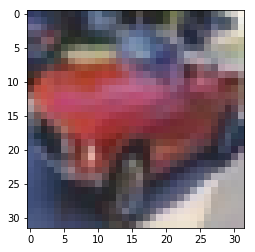

In [269]:
print_original(X_test[num], Y_test[num])

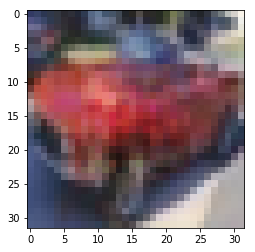

In [270]:
print_result(X_test[num])

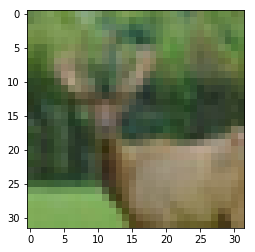

In [36]:
print_original(X_test[876], Y_test[876])

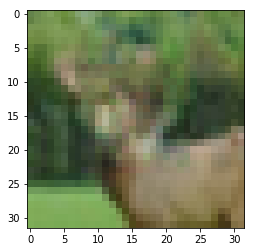

In [37]:
print_result(X_test[876])

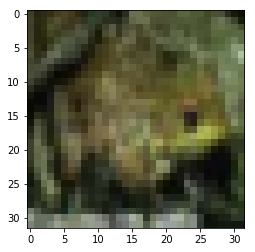

In [38]:
print_original(X_test[107], Y_test[107])

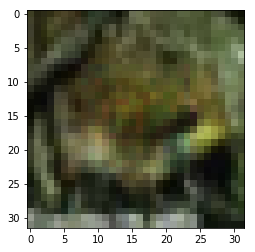

In [39]:
print_result(X_test[107])

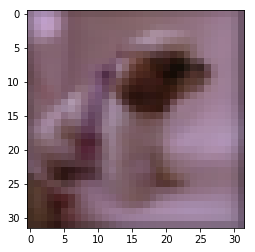

In [40]:
print_original(X_test[178], Y_test[178])

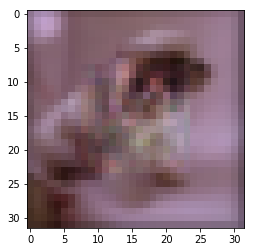

In [41]:
print_result(X_test[178])

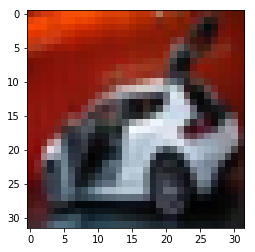

In [42]:
print_original(X_test[6], Y_test[6])

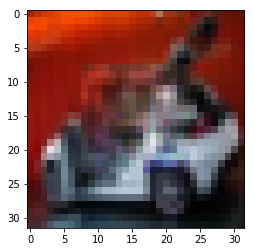

In [43]:
print_result(X_test[6])

C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


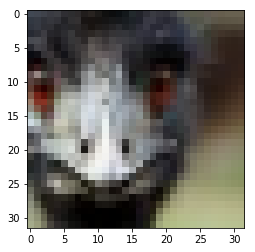

In [54]:
print_original(X_test[35], Y_test[35])

C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


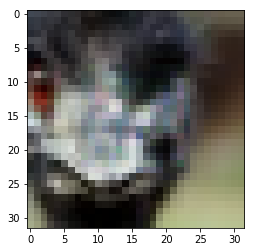

In [55]:
print_result(X_test[35])